<a href="https://colab.research.google.com/github/wildtulipan/BasalGangliaOutput_LFP/blob/main/LFP_SNr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [ ]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Research/LFP_SNr

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Research/LFP_SNr


In [ ]:
#@title Import Dependencies
# Dependencies needed
import numpy as np
import scipy.fftpack as fftpack
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatter
from scipy import signal
import h5py
import pandas as pd
from brPy import brpylib, brMiscFxns # Blackrock Utilities
import cupy as cp
from scipy import fftpack



In [ ]:
#@title Helper Functions
def wavelet_tf(data, Fs, min_freq, max_freq, num_freq):
    """
    Compute the time-frequency representation of the input data using complex Morlet wavelets.

    Parameters:
    - data: 1D numpy array, the input signal.
    - Fs: int, the sampling frequency of the data.
    - min_freq: float, the minimum frequency of interest.
    - max_freq: float, the maximum frequency of interest.
    - num_freq: int, the number of frequencies to analyze between min_freq and max_freq.

    Returns:
    - wavelet_TF: 2D numpy array, the time-frequency representation of the data.
    """
    # Time vector
    time = np.arange(0, 6 * Fs) / Fs
    time = time - np.mean(time)

    # Length of data and kernel
    nData = len(data)
    nKern = len(time)
    nConv = nData + nKern - 1
    halfK = int(np.floor(nKern / 2))

    # Frequency vector
    frex = np.linspace(min_freq, max_freq, num_freq)

    # Initialize the time-frequency matrix
    wavelet_TF = []

    for freq in frex:
        # Create the complex Morlet wavelet
        fwhm = 0.5 + (1 / freq)  # full width at half maximum
        sine_wave = np.exp(1j * 2 * np.pi * freq * time)
        gaussian = np.exp((-4 * np.log(2) * time**2) / (fwhm**2))
        cmw = sine_wave * gaussian

        # Convolution in the frequency domain
        cmwX = fftpack.fft(cmw, nConv)
        cmwX = cmwX / np.max(cmwX)
        dataX = fftpack.fft(data, nConv)
        convolutionX = cmwX * dataX

        # Inverse FFT to get the time-domain result
        convres = fftpack.ifft(convolutionX)
        convres = convres[halfK:-halfK+1]  # cutoff the wings

        # Append the result to the time-frequency matrix
        wavelet_TF.append(convres)

    # Stack the results into a 2D array
    wavelet_TF = np.vstack(wavelet_TF)

    return wavelet_TF

def wavelet_tf_gpu(data, Fs, min_freq, max_freq, num_freq):
    """GPU-accelerated wavelet transform using CuPy"""
    # Transfer data to GPU
    data_gpu = cp.asarray(data)

    # Time vector
    time = cp.arange(0, 6 * Fs) / Fs
    time = time - cp.mean(time)

    # Length of data and kernel
    nData = len(data)
    nKern = len(time)
    nConv = nData + nKern - 1
    halfK = int(cp.floor(nKern / 2))

    # Frequency vector
    frex = cp.linspace(min_freq, max_freq, num_freq)

    # Initialize the time-frequency matrix
    wavelet_TF = cp.zeros((num_freq, nData), dtype=cp.complex128)

    for i, freq in enumerate(frex):
        # Create the complex Morlet wavelet
        fwhm = 0.5 + (1 / freq)
        sine_wave = cp.exp(1j * 2 * cp.pi * freq * time)
        gaussian = cp.exp((-4 * cp.log(2) * time**2) / (fwhm**2))
        cmw = sine_wave * gaussian

        # Convolution in the frequency domain
        cmwX = cp.fft.fft(cmw, nConv)
        cmwX = cmwX / cp.max(cp.abs(cmwX))
        dataX = cp.fft.fft(data_gpu, nConv)
        convolutionX = cmwX * dataX

        # Inverse FFT to get the time-domain result
        convres = cp.fft.ifft(convolutionX)
        convres = convres[halfK:-halfK+1]

        # Store in the time-frequency matrix
        wavelet_TF[i] = convres

    # Transfer result back to CPU
    return cp.asnumpy(wavelet_TF)

def lowpass_filter(data, cutoff, fs, order=5):
    """
    Apply a low-pass Butterworth filter to the input data.

    Parameters:
        data (ndarray): Input data to be filtered.
        cutoff (float): Cutoff frequency in Hz.
        fs (float): Sampling frequency in Hz.
        order (int): Order of the filter (default is 5).

    Returns:
        y (ndarray): Filtered data.
    """
    # Design the filter
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)

    # Apply the filter
    y = signal.filtfilt(b, a, data)  # Zero-phase filtering
    return y

In [ ]:
#@title Load NS6 & NEV Files
# Extract and load the LFP data
NsxPath = Path("./R4/17-12-23/Raton4_171223001.ns6")
NevPath = Path("./R4/17-12-23/Raton4_171223001_sorted.nev")
H5_path = Path("./R4/17-12-23/R4_171223DLC_resnet50_Registros del Segundo Grupo Apr16shuffle1_200000.h5")

# Open file and extract NsxFile
NsxFile = brpylib.NsxFile(str(NsxPath))
NSx_data = NsxFile.getdata()
NsxFile.close() # Close the nsx file now that all data is out

# Open file and extract NevFile
NevFile = brpylib.NevFile(str(NevPath))
NEV_data = NevFile.getdata()
NevFile.close()

# Extract DeepLabCut data
DeepLabCut = pd.read_hdf(H5_path)


Raton4_171223001.ns6 opened

Raton4_171223001.ns6 closed

Raton4_171223001_sorted.nev opened

Raton4_171223001_sorted.nev closed


In [ ]:
#@title Load and Filter LFP Data
TimeStamps = NEV_data["digital_events"]["TimeStamps"] # Sample point at which an event ocurred
EventType = NEV_data["digital_events"]["UnparsedData"] # Type of event (16, 123, etc...)
LFP_matrix = NSx_data["data"][0] # LFP matrix of Channels by Time (memmap)
channel = 1
electrode = LFP_matrix[channel,:]

# Reduce the signal from 30,000 a 1,000 Hz sampling rate
downsampled_electrode = signal.decimate(electrode, 30, axis=0)
TimeStamps = [int(timestamp / 30) for timestamp in TimeStamps]
cutoff_freq = 50 # This filters 50-60 Hz line noise
Fs = 1000 # New sampling frequenncy
filtered_electrode = lowpass_filter(downsampled_electrode, cutoff_freq, Fs)

In [ ]:
#@title Wavelet Transform
# frequency parameters
min_freq = 5  # in Hz
max_freq = 50  # in Hz
num_freq = 100  # in count
Fs = 1000
# Compute the wavelet transform
wavelet_TF = wavelet_tf_gpu(downsampled_electrode, Fs, min_freq, max_freq, num_freq)
amplitude_TF = np.abs(wavelet_TF)**2
amplitude_TF = ((np.maximum(amplitude_TF, 1e-10) - np.maximum(np.mean(amplitude_TF, axis=1, keepdims=True),1e-10))/np.maximum(np.std(amplitude_TF, axis=1, keepdims=True),1e-10))
# amplitude_TF = 10 * np.log10(np.maximum(amplitude_TF, 1e-10)/np.maximum(np.mean(amplitude_TF, axis=1, keepdims=True), 1e-10))
# amplitude_TF = 100 * ((amplitude_TF - np.mean(amplitude_TF, axis=1, keepdims=True))/np.mean(amplitude_TF, axis=1, keepdims=True))
# Uncomment for the non gpu version
# wavelet_TF = wavelet_tf(downsampled_electrode, Fs, min_freq, max_freq, num_freq)

## Data Exploration

In [ ]:
# Set up the time stamp for the exploration window
start_time = 300        # in seconds
stop_time = 400         # in seconds

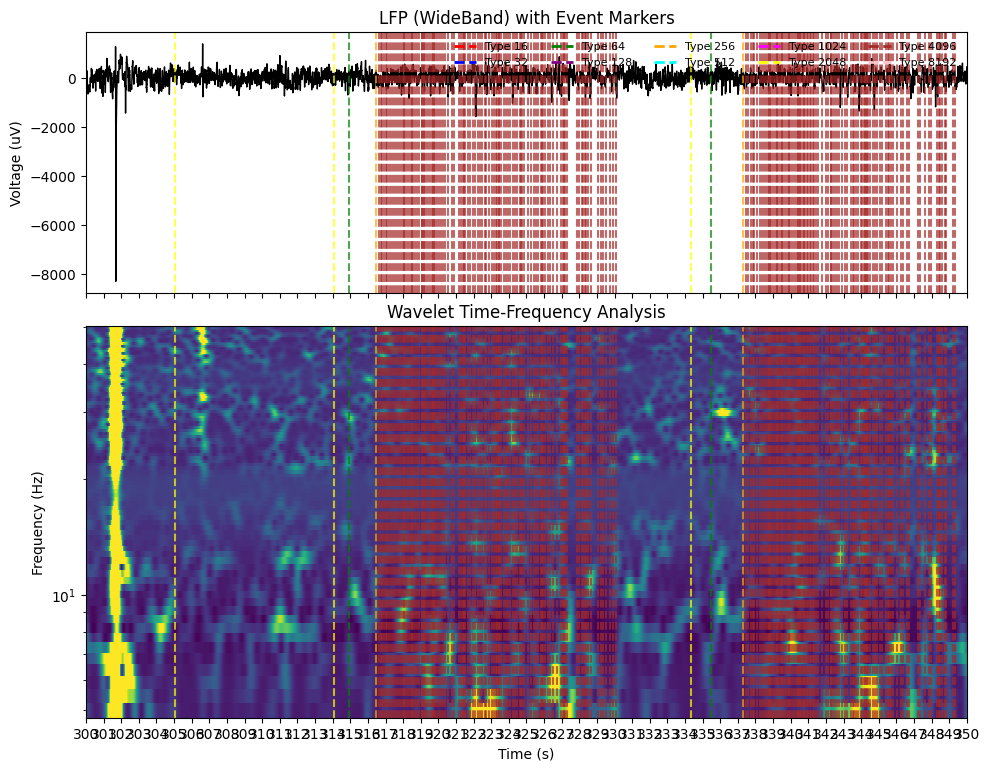

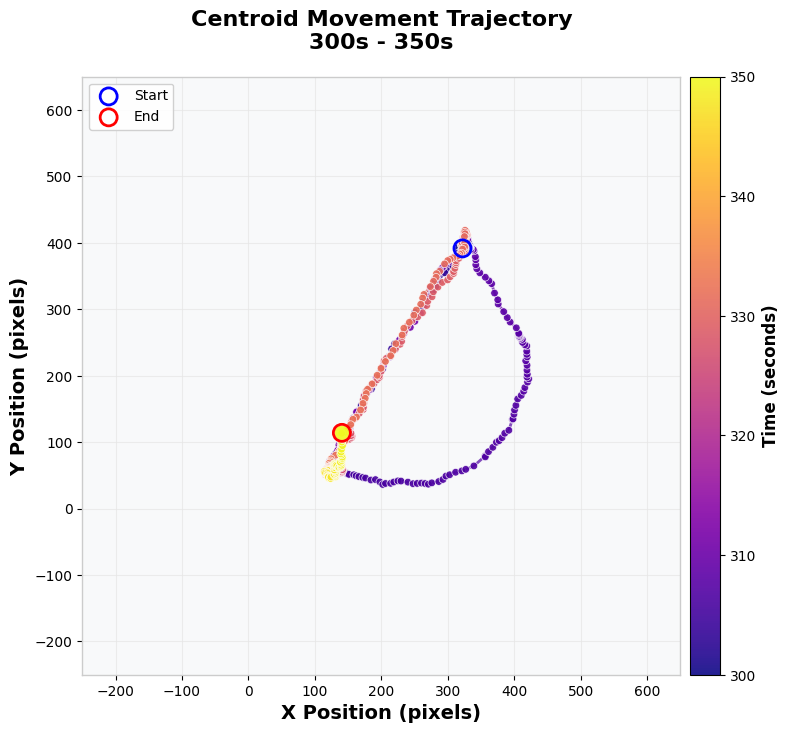

In [ ]:
#@title LFP-Wavlet viewer
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

# Create a figure with a simpler layout - just two plots stacked vertically
fig = plt.figure(figsize=(10, 8))

# Create a 2x1 grid with custom height ratio
gs = GridSpec(2, 1, height_ratios=[1, 1.5])  # Top plot slightly smaller than bottom

# --- LFP PLOT (top) ---
ax_lfp = fig.add_subplot(gs[0])

# Convert time to samples
start_sample = start_time * 1000
stop_sample = stop_time * 1000
sampling_rate = 1000  # Hz

# Define a color map for each event type
event_color_map = {
    16: 'red',
    32: 'blue',
    64: 'green',
    128: 'purple',
    256: 'orange',
    512: 'cyan',
    1024: 'magenta',
    2048: 'yellow',
    4096: 'brown',
    8192: 'pink'
}

# Process events for the window
events_in_window = []
event_types_in_window = []
plot_positions = []

for i, ts in enumerate(TimeStamps):
    if start_sample <= ts < stop_sample:
        events_in_window.append(ts)
        event_types_in_window.append(EventType[i])
        plot_positions.append(ts - start_sample)

# Plot LFP signal
x_samples = np.arange(len(filtered_electrode[start_sample:stop_sample]))
ax_lfp.plot(x_samples, filtered_electrode[start_sample:stop_sample], linewidth=1, color="black")

# Add event markers
for pos, event_type in zip(plot_positions, event_types_in_window):
    color = event_color_map.get(event_type, 'gray')
    if color == "red" or color == "blue":
      continue
    else:
      ax_lfp.axvline(x=pos, color=color, linestyle='--', alpha=0.7)

ax_lfp.set_ylabel("Voltage (uV)")
ax_lfp.set_title("LFP (WideBand) with Event Markers")
ax_lfp.set_xlim(0, stop_sample - start_sample)

# Set up x-axis ticks showing time in seconds of the total recording
# Calculate tick positions every 1 second
tick_interval_sec = 1  # 1 second intervals
tick_interval_samples = tick_interval_sec * sampling_rate
num_ticks = int((stop_sample - start_sample) / tick_interval_samples) + 1
tick_positions = np.arange(0, stop_sample - start_sample + 1, tick_interval_samples)
tick_labels = [f"{start_time + i * tick_interval_sec:.0f}" for i in range(num_ticks)]

# Remove x-axis labels from top plot (they'll be on bottom plot)
ax_lfp.set_xticks(tick_positions)
ax_lfp.set_xticklabels([])

# Create event legend
legend_elements = [Line2D([0], [0], color=color, linestyle='--', lw=2, label=f'Type {event_type}')
                  for event_type, color in event_color_map.items()]
ax_lfp.legend(handles=legend_elements, loc='upper right', ncol=5, frameon=False, fontsize=8)

# --- WAVELET PLOT (bottom) ---
ax_wavelet = fig.add_subplot(gs[1])

# Create wavelet plot
amplitude = amplitude_TF[:, start_sample:stop_sample]

# Create frequency axis
y = np.linspace(5, 50, 100)  # Your original frequencies
x = np.linspace(0, amplitude.shape[1], amplitude.shape[1])  # Time axis

# Create the colormap plot

pcm = ax_wavelet.pcolormesh(x, y, amplitude, cmap='viridis', vmax=4)

# Add event markers to wavelet plot
for pos, event_type in zip(plot_positions, event_types_in_window):
    color = event_color_map.get(event_type, 'gray')
    if color == "red" or color == "blue":
      continue
    else:
      ax_wavelet.axvline(x=pos, color=color, linestyle='--', alpha=0.7)

# Set up labels
ax_wavelet.set_xlabel("Time (s)")
ax_wavelet.set_ylabel("Frequency (Hz)")
ax_wavelet.set_title("Wavelet Time-Frequency Analysis")

# Set logarithmic scale for y-axis (frequency)
ax_wavelet.set_yscale('log')

# Make sure the x-axis aligns with the LFP plot
ax_wavelet.set_xlim(0, stop_sample - start_sample)

# Set up x-axis ticks showing time in seconds of the total recording
ax_wavelet.set_xticks(tick_positions)
ax_wavelet.set_xticklabels(tick_labels)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.1)  # Make room for title and reduce space between plots

plt.show()

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Extract DeepLabCut Coordinates
start_sample = start_time * 30
stop_sample = stop_time * 30

coords = DeepLabCut['DLC_resnet50_Registros del Segundo Grupo Apr16shuffle1_200000']['Centroide']
coords = coords.iloc[start_sample:stop_sample]

# Create figure with a square aspect ratio
fig, ax = plt.subplots(figsize=(8, 8), facecolor='white')
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

# Create a clean white background with a subtle grid
ax.set_facecolor('#f8f9fa')
ax.grid(color='#e6e6e6', linestyle='-', linewidth=0.8, alpha=0.7)

# Create a better color sequence based on time in seconds
time_in_seconds = np.linspace(start_time, stop_time, len(coords))
points = np.array([coords['x'], coords['y']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a continuous color-mapped line to show the path
norm = plt.Normalize(time_in_seconds.min(), time_in_seconds.max())
lc = LineCollection(segments, cmap='plasma', norm=norm, alpha=0.7, linewidth=2)
lc.set_array(time_in_seconds[:-1])
line = ax.add_collection(lc)

# Add scatter points with the same color mapping but larger at start/end
scatter_sizes = np.ones(len(coords)) * 30  # Base size
scatter_sizes[0] = 120  # Start point bigger
scatter_sizes[-1] = 120  # End point bigger

scatter = ax.scatter(
    coords["x"],
    coords["y"],
    c=time_in_seconds,
    cmap='plasma',
    s=scatter_sizes,
    alpha=0.9,
    edgecolor='white',
    linewidth=0.5,
    zorder=3
)

# Highlight start and end points
ax.scatter(coords["x"].iloc[0], coords["y"].iloc[0], s=150, facecolors='none',
           edgecolors='blue', linewidth=2, label='Start', zorder=4)
ax.scatter(coords["x"].iloc[-1], coords["y"].iloc[-1], s=150, facecolors='none',
           edgecolors='red', linewidth=2, label='End', zorder=4)

# Set axis limits with a bit of padding
ax.set_xlim([-250, 650])
ax.set_ylim([-250, 650])
ax.set_aspect('equal')

# Add a border around the plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('#cccccc')
    spine.set_linewidth(1)

# Better axis labels with custom font
ax.set_xlabel('X Position (pixels)', fontsize=14, fontweight='bold')
ax.set_ylabel('Y Position (pixels)', fontsize=14, fontweight='bold')
ax.set_title(f'Centroid Movement Trajectory\n{start_time}s - {stop_time}s',
             fontsize=16, fontweight='bold', pad=20)

# Add a nicer, vertical colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(scatter, cax=cax)
cbar.set_label('Time (seconds)', fontsize=12, fontweight='bold')

# Add legend for start/end points
ax.legend(loc='upper left', frameon=True, framealpha=0.9,
          fontsize=10, edgecolor='#cccccc')

# Add gridlines that are behind the data
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()